**This notebook is for evaluation of scAR on public scRNAseq data.**
___

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scanpy as sc
import numba
import anndata as ad

from natsort import natsorted, ns
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
from sklearn.metrics import r2_score, median_absolute_error

# polt setting

In [2]:
#publication quality plots
from matplotlib import pylab

params = {'legend.fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (4, 3),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'pdf.fonttype': 42,
         'figure.autolayout': True,
         'axes.grid':False,
         "figure.dpi":150}

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
# pylab.rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':10});
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
# Set the font used for MathJax - more on this later
pylab.rc('mathtext',**{'default':'regular'});

pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

<Figure size 600x450 with 0 Axes>

# Examine the droplets

In [3]:
filterd_h5 = sc.read_10x_h5('/da/onc/bfx/research/shengca1/public_data/10xgenomics/20k_hgmm_3p_HT/20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5');
filterd_h5.var_names_make_unique();
raw_h5 = sc.read_10x_h5('/da/onc/bfx/research/shengca1/public_data/10xgenomics/20k_hgmm_3p_HT/20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5');
raw_h5.var_names_make_unique();

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
sc.pp.calculate_qc_metrics(filterd_h5, inplace=True)

In [ ]:
filterd_h5.obs.describe()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
count,18299.000000,18299.000000,18299.000000,18299.000000,18299.000000,18299.000000,18299.000000,18299.000000
mean,4870.701568,8.274849,25600.677734,9.783749,36.162482,48.345902,57.244701,68.625370
std,2371.144620,0.813772,16927.070312,1.078735,11.984714,10.528621,9.888067,10.392882
min,130.000000,4.875197,515.000000,6.246107,14.996386,20.681763,28.246206,42.471694
25%,3744.000000,8.228177,14780.000000,9.601098,30.160662,42.437512,51.463557,62.258424
50%,4973.000000,8.511980,24385.000000,10.101765,33.031918,46.298001,55.477956,66.520355
75%,6300.000000,8.748464,34187.500000,10.439645,36.968139,51.547395,60.593308,71.449275
max,15562.000000,9.652652,139775.000000,11.847796,93.129476,96.587031,100.000000,100.000000


In [6]:
## filter out genes < 200 counts in total
sc.pp.filter_genes(filterd_h5, min_counts=200);
sc.pp.filter_genes(filterd_h5, max_counts=6000);
sc.pp.filter_cells(filterd_h5, min_genes=200);

In [7]:
raw_h5 = raw_h5[:, filterd_h5.var_names]

In [8]:
def deterimine_empty_droplets(adata_raw, adata_filtered, sample, threshold=30):
    
    rank_UMIs = pd.DataFrame(adata_raw.X.sum(axis=1), index = adata_raw.obs_names, columns=['total_counts'])
    rank_UMIs['droplets'] = 'droplets III'
    rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>threshold, 'empty droplets')
    rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs.index.isin(adata_filtered.obs_names), 'cells')
    rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
    rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
    
    fig = plt.figure(figsize=(4,3))

    ax = sns.lineplot(data = rank_UMIs,
                 x='rank',
                 y='total_counts',
                 hue='droplets',
                 markers=False,
                 lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('sorted droplet')
    ax.legend(loc='upper right', ncol=1, title=None, frameon=False)
    ax.set_title(f'kneeplot: {sample}')

    sns.set_palette("muted")
    sns.set_style("ticks")
    sns.despine(offset=10, trim=False);

    plt.show()
    return rank_UMIs.loc[rank_UMIs['droplets'] == 'empty droplets', 'index']

In [9]:
rank_UMIs = pd.DataFrame(raw_h5.X.sum(axis=1), index = raw_h5.obs_names, columns=['total_counts'])

rank_UMIs['droplets'] = 'droplets III'
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>12, 'droplets II')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>40, 'droplets I')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs.index.isin(filterd_h5.obs_names), 'cells')
rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
rank_UMIs = rank_UMIs.set_index('index').rename_axis('cells')

In [10]:
color_code_blues = sns.color_palette("Blues_r", 4)

In [11]:
droplets_counts_all = pd.DataFrame(index=pd.MultiIndex.from_product([['counts', 'ratio'], rank_UMIs['droplets'].unique()]), columns=['human', 'mouse'])

for dl in rank_UMIs['droplets'].unique():
    droplets = raw_h5[rank_UMIs[rank_UMIs['droplets']==dl].index]
    droplets.obs['human gene counts'] = droplets[:, droplets.var['genome']=="GRCh38"].X.A.sum(axis=1)
    droplets.obs['mouse gene counts'] = droplets[:, droplets.var['genome']=="mm10"].X.A.sum(axis=1)

    droplets_counts = droplets.obs.sum(axis=0).to_frame('counts')
    droplets_counts['count ratio'] = droplets_counts/droplets_counts.sum()
    droplets_counts_all.loc[('counts', dl), 'human'] = droplets_counts.loc['human gene counts', 'counts']
    droplets_counts_all.loc[('counts', dl), 'mouse'] = droplets_counts.loc['mouse gene counts', 'counts']
    droplets_counts_all.loc[('ratio', dl), 'human'] = droplets_counts.loc['human gene counts', 'count ratio']
    droplets_counts_all.loc[('ratio', dl), 'mouse'] = droplets_counts.loc['mouse gene counts', 'count ratio']


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [12]:
droplets_counts_all

human       mouse
counts cells         18894022.0  16820760.0
       droplets I      324425.0    131449.0
       droplets II    2210880.0    899482.0
       droplets III    312506.0    241888.0
ratio  cells           0.529025    0.470975
       droplets I      0.711655    0.288345
       droplets II     0.710811    0.289189
       droplets III    0.563689    0.436311

(0.0, 1.0)

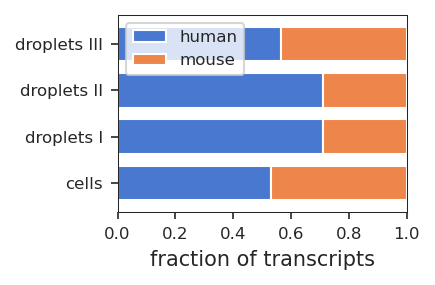

In [13]:
droplets_counts_all.loc['ratio'].plot.barh(stacked=True,figsize=(3,2),width=0.75)
plt.xlabel("fraction of transcripts")
plt.xlim(0,1)
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/counts_characterization_all.pdf', doi=200)

In [14]:
for idx,row in droplets_counts_all.iterrows():
    print(idx)
    hc = row['human']
    mc = row['mouse']
    print(f'{hc:0.2e}', f'{mc:0.2e}',)

('counts', 'cells')
1.89e+07 1.68e+07
('counts', 'droplets I')
3.24e+05 1.31e+05
('counts', 'droplets II')
2.21e+06 8.99e+05
('counts', 'droplets III')
3.13e+05 2.42e+05
('ratio', 'cells')
5.29e-01 4.71e-01
('ratio', 'droplets I')
7.12e-01 2.88e-01
('ratio', 'droplets II')
7.11e-01 2.89e-01
('ratio', 'droplets III')
5.64e-01 4.36e-01


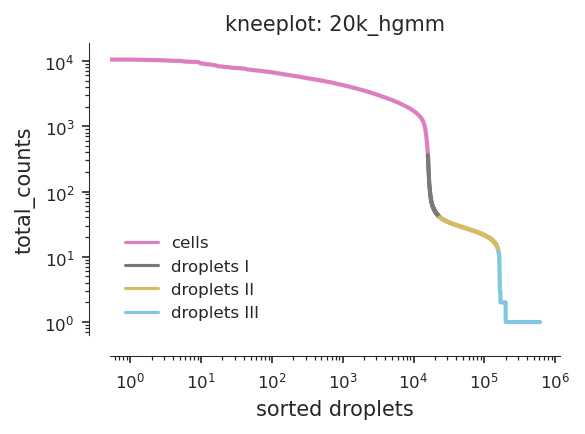

In [15]:
fig = plt.figure(figsize=(4,3))

ax = sns.lineplot(data = rank_UMIs,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplets I', 'droplets II', 'droplets III'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: 20k_hgmm');

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

# fig.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/droplets_characterization.pdf', doi=200)

In [16]:
freq = pd.DataFrame(columns=raw_h5.var_names, index=['cells', 'droplets I', 'droplets II', 'droplets III', 'dropletsI-III'])

cell_droplets = raw_h5[raw_h5.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='cells'].index)].X.A.sum(axis=0)
freq.loc['cells']=cell_droplets/cell_droplets.sum()

droplets1 = raw_h5[raw_h5.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='droplets I'].index)].X.A.sum(axis=0)
freq.loc['droplets I']=droplets1/droplets1.sum()

droplets2 = raw_h5[raw_h5.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='droplets II'].index)].X.A.sum(axis=0)
freq.loc['droplets II']=droplets2/droplets2.sum()

droplets3 = raw_h5[raw_h5.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='droplets III'].index)].X.sum(axis=0)
freq.loc['droplets III']=droplets3/droplets3.sum()

non_cell_droplets = raw_h5[raw_h5.obs_names.isin(rank_UMIs[rank_UMIs['droplets'].isin(['droplets I', 'droplets II', 'droplets III'])].index)].X.sum(axis=0)
freq.loc['dropletsI-III']=non_cell_droplets/non_cell_droplets.sum()

In [17]:
freq

,GRCh38_AL627309.5,GRCh38_LINC01128,GRCh38_LINC00115,GRCh38_FAM41C,GRCh38_AL645608.2,GRCh38_LINC02593,GRCh38_SAMD11,GRCh38_KLHL17,GRCh38_AL645608.7,GRCh38_ISG15,...,mm10___Gm21887,mm10___Kdm5d,mm10___Eif2s3y,mm10___Uty,mm10___Ddx3y,mm10___AC133103.1,mm10___AC168977.1,mm10___CAAA01118383.1,mm10___Spry3,mm10___Tmlhe
cells,0.000009,0.000083,0.000009,0.000011,0.000021,0.000045,0.00013,0.000036,0.000047,0.000119,...,0.000012,0.000021,0.000056,0.000021,0.000139,0.000017,0.00001,0.000062,0.000025,0.000017
droplets I,0.000004,0.000129,0.000009,0.000009,0.000004,0.000037,0.000211,0.000048,0.000066,0.000208,...,0.000004,0.000004,0.000031,0.000007,0.000092,0.000015,0.00002,0.000024,0.000007,0.000015
droplets II,0.000004,0.000116,0.000009,0.000018,0.000005,0.000048,0.000185,0.000051,0.000049,0.000195,...,0.000007,0.00001,0.000034,0.000009,0.000079,0.00001,0.000009,0.000029,0.000015,0.000006
droplets III,0.000005,0.000092,0.000013,0.00002,0.000013,0.000041,0.000105,0.000034,0.000045,0.000141,...,0.000009,0.00002,0.000029,0.000013,0.00013,0.000011,0.000011,0.000052,0.000023,0.000022
dropletsI-III,0.000004,0.000114,0.00001,0.000017,0.000006,0.000046,0.000177,0.000049,0.00005,0.00019,...,0.000007,0.000011,0.000033,0.000009,0.000087,0.000011,0.00001,0.000032,0.000015,0.000009


## R2 scores

In [18]:
dros1 = r2_score(freq.T['cells'], freq.T['droplets I'])
dros2 = r2_score(freq.T['cells'], freq.T['droplets II'])
dros3 = r2_score(freq.T['cells'], freq.T['droplets III'])
dros4 = r2_score(freq.T['cells'], freq.T['dropletsI-III'])

R2_dros = [dros1, dros2, dros3, dros4]

In [19]:
sns.color_palette()

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

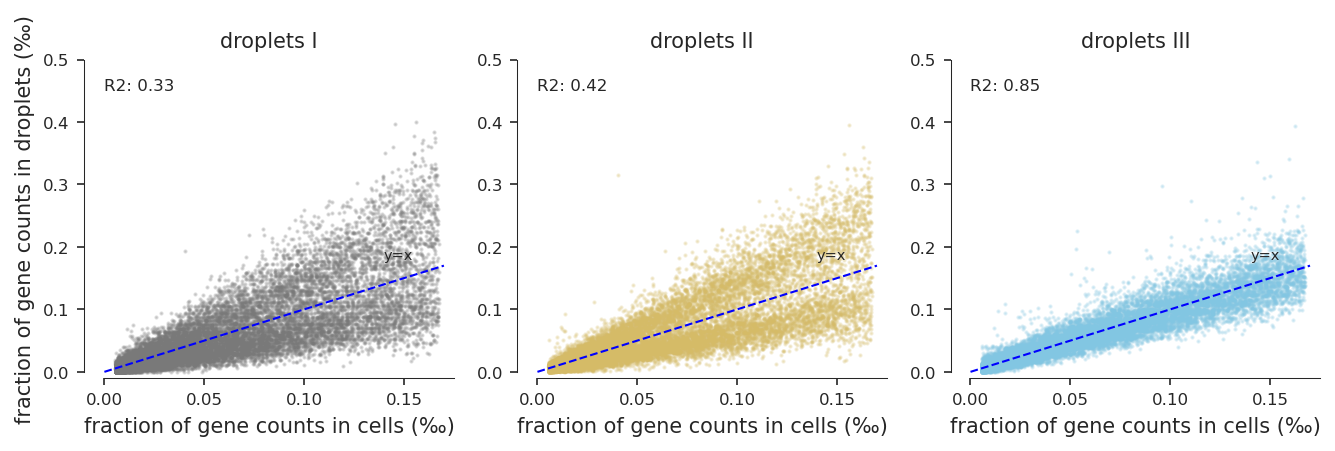

In [20]:
freq_1000 = freq*1000

fig, axes = plt.subplots(1, 3, figsize=(9,3))
fig.subplots_adjust(hspace=0.05, wspace=0.05)                                    

axes[0].scatter(x=freq_1000.loc['cells'], y=freq_1000.loc['droplets I'],rasterized=True, s=1, alpha=0.25, color=sns.color_palette()[-3]);
axes[0].set_title('droplets I')
axes[1].scatter(x=freq_1000.loc['cells'], y=freq_1000.loc['droplets II'],rasterized=True, s=1, alpha=0.25, color=sns.color_palette()[-2]);
axes[1].set_title('droplets II')
axes[2].scatter(x=freq_1000.loc['cells'], y=freq_1000.loc['droplets III'],rasterized=True, s=1, alpha=0.25, color=sns.color_palette()[-1]);
axes[2].set_title('droplets III')

for i,ax in enumerate(axes.flatten()):
    ax.set_xlim((-0.01, 0.175))
    ax.set_ylim((-0.01, 0.5))
    ax.set_xlabel('fraction of gene counts in cells (‰)')
    if i == 0:
        ax.set_ylabel('fraction of gene counts in droplets (‰)')
    ax.plot([0,0.17], [0,0.17], 'b--', linewidth = 1)
    ax.text(0, 0.45, f'R2: {R2_dros[i]:.2f}', fontsize=8)
    ax.text(0.14, 0.18, f'y=x', fontsize=7)
    ax.spines['bottom'].set_bounds((0, 0.175))
    ax.spines['left'].set_bounds((0, 0.5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/droplets_cell_correlation.pdf', doi=200)

In [21]:
freq_unpivoted = freq.T.melt(id_vars=['cells'], var_name='droplets', value_name='fraction of genes')
freq_unpivoted['fraction of gene counts in cells (‰)'] = freq_unpivoted['cells'] * 1000
freq_unpivoted['fraction of gene counts in droplets (‰)'] = freq_unpivoted['fraction of genes'] * 1000

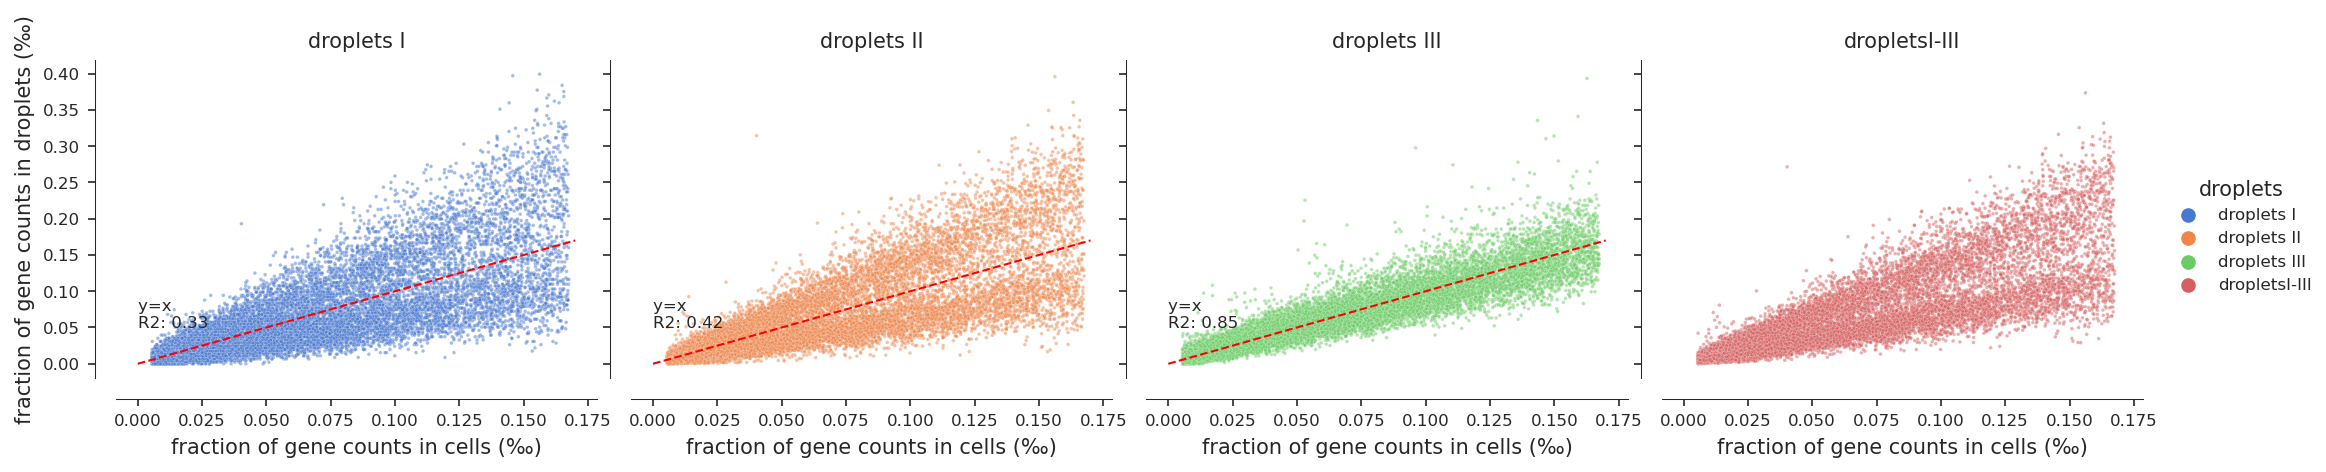

In [22]:
g = sns.relplot(data=freq_unpivoted,
                x="fraction of gene counts in cells (‰)",
                y="fraction of gene counts in droplets (‰)",
                col="droplets",
                hue='droplets',
                s=3,
                alpha=0.5,
                kind="scatter",
                height=3,
                aspect=1.2,
               );

for i in range(3):
    g.axes[0,i].plot([0,0.17], [0,0.17], 'r--', linewidth = 1)
    g.axes[0,i].text(0, 0.05, f'y=x \nR2: {R2_dros[i]:.2f}', fontsize=8)
    
g.set_titles('{col_name}')
sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/droplets_cell_correlation.pdf', doi=200)

In [23]:
for d in ['cells', 'droplets III', 'droplets II', 'droplets I', 'non_cells']:
    empty_droplets = raw_h5[rank_UMIs[rank_UMIs['droplets']==d].index][:, filterd_h5.var_names]
    empty_profile = empty_droplets.X.sum(axis=0)/empty_droplets.X.sum()
    file_name = d.replace(' ','')
    pd.DataFrame(empty_profile, columns=filterd_h5.var_names).T.to_pickle(f'20k_hgmm_empty_profile_{file_name}.pickle')

/tmp/ipykernel_88110/2755737133.py:3: RuntimeWarning: invalid value encountered in true_divide
  empty_profile = empty_droplets.X.sum(axis=0)/empty_droplets.X.sum()


In [24]:
raw_counts = filterd_h5.to_df()
raw_counts.astype(int).to_pickle('/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/scRNAseq/mixture/20k_hgmm_count_matrix.pickle')

In [25]:
pd_list = []
for d in ['cells', 'droplets III', 'droplets II', 'droplets I']:
    file_name = d.replace(' ','')
    pd_list.append(pd.read_pickle(f'20k_hgmm_empty_profile_{file_name}.pickle'))

# UMAP to determine cell species

In [26]:
def process_adata(adata, min_genes=200, min_counts = 1500, min_cells=10):

    adata_out = adata.copy()

    sc.pp.calculate_qc_metrics(adata_out, inplace=True)
    # sc.pp.filter_genes(adata_out, min_cells=min_cells)

    sc.pp.normalize_total(adata_out, target_sum=1e4)
    sc.pp.log1p(adata_out)  # log normalization works well for this dataset
    
    sc.pp.scale(adata_out, max_value=10)
    sc.tl.pca(adata_out, svd_solver='arpack')
    sc.pp.neighbors(adata_out, n_neighbors=50, n_pcs=10)
    sc.tl.leiden(adata_out, key_added='leiden_clusters', resolution=0.2, random_state=11) #, resolution=resolution
    sc.tl.umap(adata_out, random_state=11)

    return adata_out

In [27]:
filterd_h5_processed = process_adata(filterd_h5)

In [28]:
sc.tl.rank_genes_groups(filterd_h5_processed, 'leiden_clusters', method='t-test_overestim_var')

... storing 'feature_types' as categorical
... storing 'genome' as categorical
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [29]:
result = filterd_h5_processed.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(30)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p
0,GRCh38_IMPA1,0.0,mm10___Tmem53,0.000000e+00,mm10___Ociad2,5.139634e-266,mm10___Sgo1,0.0,GRCh38_GOLGA8A,1.127712e-65,GRCh38_TXNRD2,7.301903e-15,mm10___Gm26724,1.467314e-07
1,GRCh38_PKIG,0.0,mm10___Haghl,9.781661e-310,mm10___Lmcd1,1.287215e-233,mm10___Mad2l1,0.0,GRCh38_GOLGA8B,8.134993e-48,GRCh38_MMS19,9.628613e-14,mm10___Paxbp1,3.177744e-07
2,GRCh38_RNF2,0.0,mm10___Gm7967,1.471940e-304,mm10___Gm40652,2.367229e-219,mm10___Chaf1a,0.0,GRCh38_TTN,6.905559e-42,GRCh38_NOC4L,1.604674e-13,mm10___Ptgs2os,9.069071e-07
3,GRCh38_COQ5,0.0,mm10___Pja1,1.170514e-298,mm10___Trem2,1.563315e-226,mm10___Pbk,0.0,GRCh38_ANKRD36,2.127674e-34,GRCh38_HSPBP1,3.289090e-13,mm10___Slc25a27,3.041596e-06
4,GRCh38_SMCO4,0.0,mm10___1110012L19Rik,1.567904e-288,mm10___Poglut2,8.417191e-223,mm10___Pimreg,0.0,GRCh38_AL022323.4,4.110285e-33,GRCh38_PRADC1,3.803792e-13,mm10___E530011L22Rik,1.051676e-05
5,GRCh38_PEPD,0.0,mm10___Lama4,3.004717e-283,mm10___Hebp1,6.972430e-222,mm10___Cenph,0.0,GRCh38_LRIG2-DT,2.462735e-31,GRCh38_SBF1,5.009119e-13,mm10___6720427I07Rik,1.553116e-05
6,GRCh38_STAM,0.0,mm10___Rcan2,3.013483e-275,mm10___Mmp16,1.226150e-208,mm10___Knl1,0.0,GRCh38_AC092338.3,6.365163e-30,GRCh38_RELA,5.388608e-13,mm10___Slc24a5,4.446992e-05
7,GRCh38_NTAN1,0.0,mm10___Zhx1,6.223132e-258,mm10___Nfia,3.692778e-212,mm10___Mcm5,0.0,GRCh38_WDR27,1.316850e-29,GRCh38_ZFYVE21,6.755294e-13,mm10___Ptbp2,6.075749e-05
8,GRCh38_RTL8B,0.0,mm10___Ctnnal1,6.389312e-256,mm10___Fnip2,8.607442e-206,mm10___Ndc80,0.0,GRCh38_PAN2,9.603258e-29,GRCh38_ZNF444,6.940845e-13,mm10___Proser1,9.412319e-05
9,GRCh38_RSU1,0.0,mm10___Azin2,1.031638e-250,mm10___Plcb4,5.334466e-203,mm10___Sgo2a,0.0,GRCh38_CCDC150,1.972232e-28,GRCh38_NSDHL,8.413483e-13,mm10___Zfp949,1.959323e-04


In [30]:
new_cluster_names = {
    "0": "HEK293T",
    "1": "NIH3T3",
    "2":"NIH3T3",
    "3":"NIH3T3",
    "4":"HEK293T",
    "5":"mixture",
    # "6":"NIH3T3",
    "6":"NIH3T3"}

filterd_h5_processed.obs['species'] = filterd_h5_processed.obs.leiden_clusters.astype("str").values
filterd_h5_processed.obs.species = filterd_h5_processed.obs.species.replace(new_cluster_names)
filterd_h5_processed.obs.species = filterd_h5_processed.obs.species.astype("category")
filterd_h5_processed.obs.species.cat.reorder_categories([
    'HEK293T', 'mixture', 'NIH3T3'], inplace=True)

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/scanpy/plotting/_utils.py:288: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


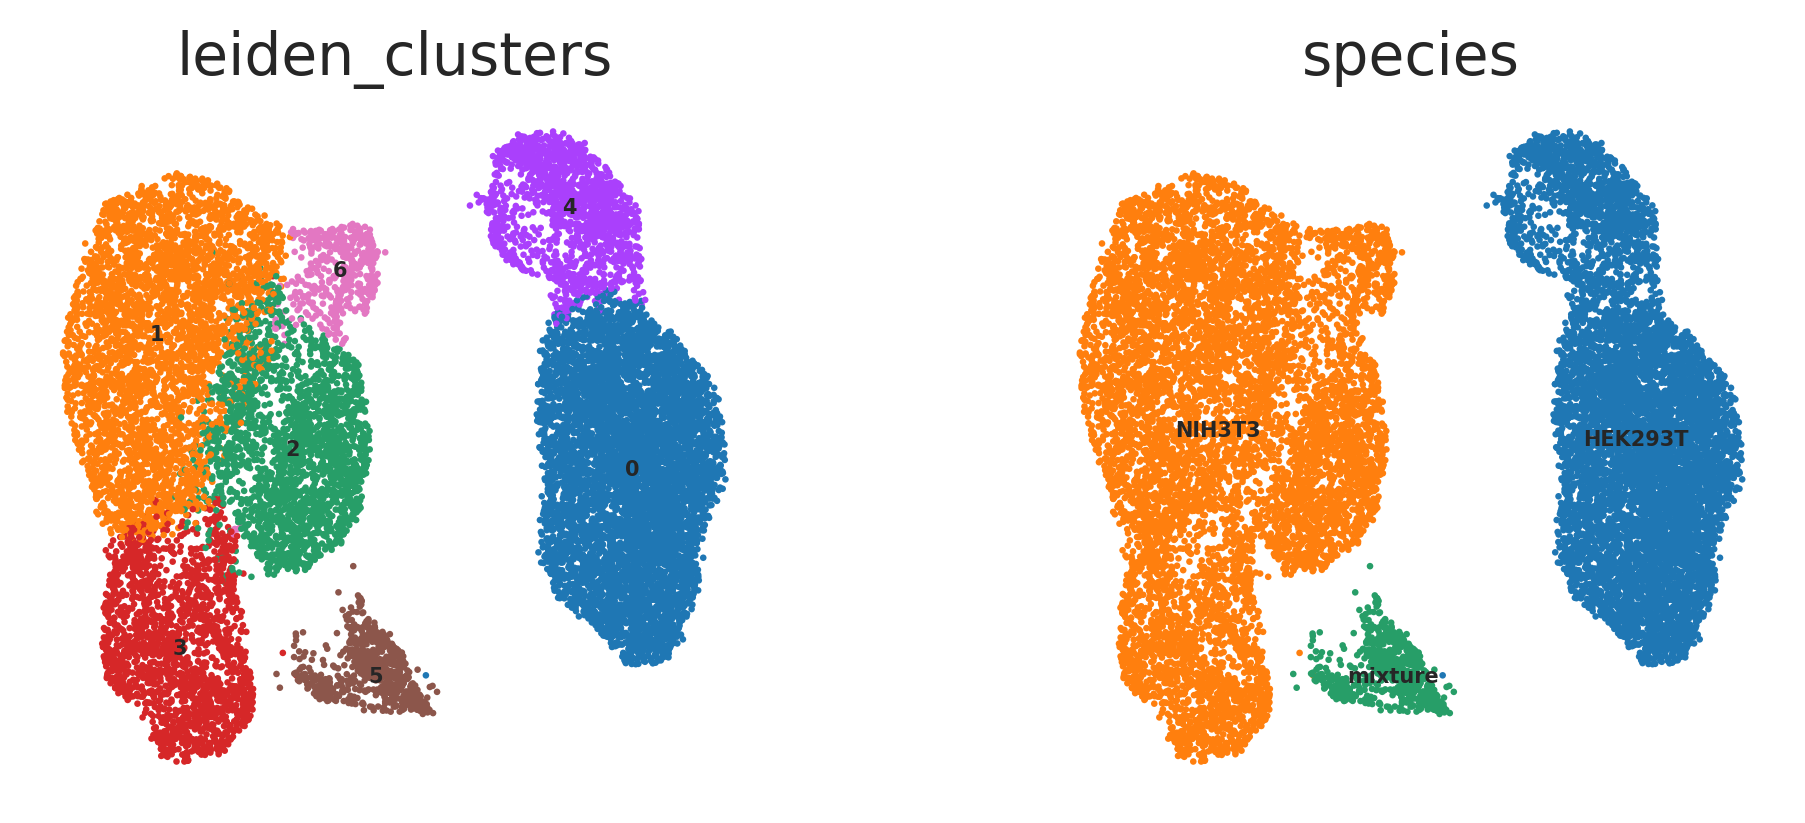

In [31]:
sc.settings.set_figure_params(dpi=150,figsize=(3, 3))
sc.pl.umap(filterd_h5_processed,
           size=10,
           color=["leiden_clusters", "species"],
           color_map="viridis",
           legend_loc="on data",
           frameon=False,
           legend_fontsize=5,
           save='20k_human_mouse_UMAP.pdf',
          )

In [32]:
filterd_h5_processed.obs.to_pickle('umap_determined_cell_species.pickle')

In [33]:
filterd_h5_processed.obs.groupby('species').count()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_genes,leiden_clusters
species,,,,,,,,,,
HEK293T,7590,7590,7590,7590,7590,7590,7590,7590,7590,7590
mixture,697,697,697,697,697,697,697,697,697,697
NIH3T3,8005,8005,8005,8005,8005,8005,8005,8005,8005,8005


# analysis

In [46]:
#publication quality plots
from matplotlib import pylab

params = {'legend.fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (4, 3),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'pdf.fonttype': 42,
         'figure.autolayout': True,
         'axes.grid':False,
         "figure.dpi":150}

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
# pylab.rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':10});
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
# Set the font used for MathJax - more on this later
pylab.rc('mathtext',**{'default':'regular'});

pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

<Figure size 600x450 with 0 Axes>

In [47]:
filterd_h5.obs['human gene counts'] = filterd_h5[:, filterd_h5.var['genome']=="GRCh38"].X.sum(axis=1)
filterd_h5.obs['mouse gene counts'] = filterd_h5[:, filterd_h5.var['genome']=="mm10"].X.sum(axis=1)

In [48]:
raw_counts = pd.read_pickle('/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/scRNAseq/mixture/20k_hgmm_count_matrix.pickle')
raw_counts = raw_counts.join(filterd_h5.obs)

In [49]:
raw_counts_df = raw_counts[['human gene counts', 'mouse gene counts']].astype(int)
raw_counts_df['human count ratio'] = raw_counts_df['human gene counts']/(raw_counts_df['mouse gene counts'] + raw_counts_df['human gene counts'])
raw_counts_df['mouse count ratio'] = raw_counts_df['mouse gene counts']/(raw_counts_df['mouse gene counts'] + raw_counts_df['human gene counts'])

raw_counts_df = raw_counts_df.join(filterd_h5_processed.obs['species'])

In [50]:
raw_counts_df['log2(human gene counts+1)'] = np.log2(raw_counts_df['human gene counts']+1)
raw_counts_df['log2(mouse gene counts+1)'] = np.log2(raw_counts_df['mouse gene counts']+1)

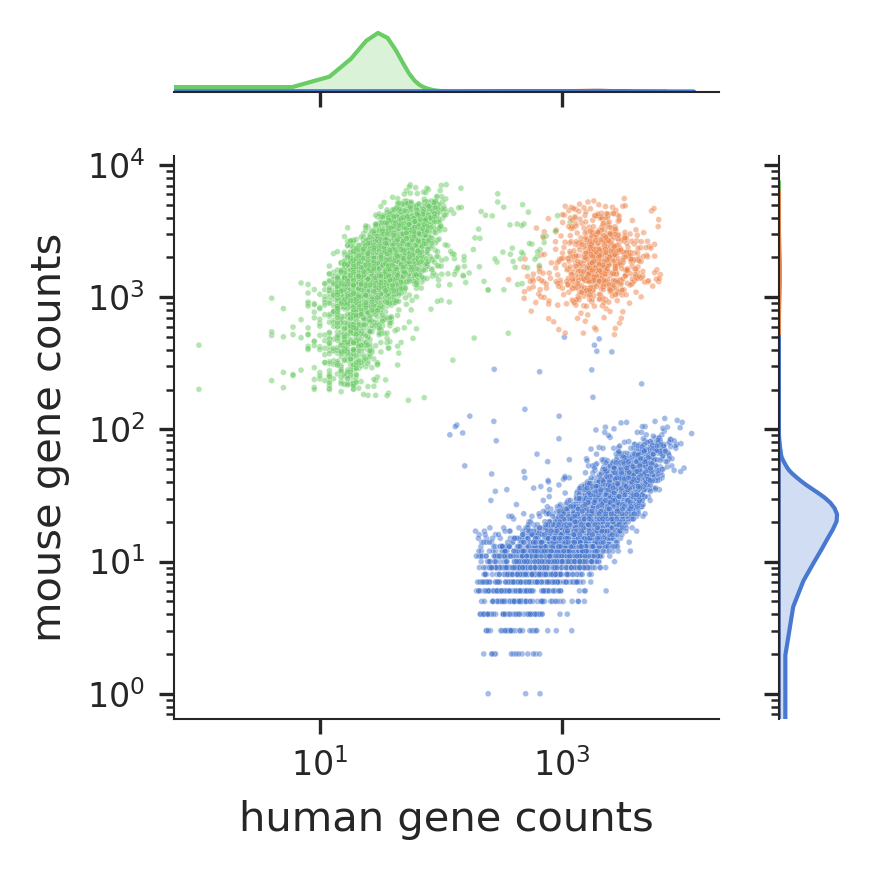

In [51]:
ax = sns.jointplot(data=raw_counts_df,
                   x="human gene counts",
                   y="mouse gene counts",                   
                   hue='species',
                   hue_order=['HEK293T', 'mixture', 'NIH3T3'],
                   s=2,
                   alpha=0.5,
                   legend=False,
                   height=3,
                   marginal_kws={'common_norm':False});
# ax.ax_joint.text(0, 0, 'raw counts');
ax.ax_joint.set_xscale('log')
ax.ax_joint.set_yscale('log')
# ax.ax_joint.set_xlim(-1, 14);
# ax.ax_joint.set_ylim(-1, 14);
# ax.ax_joint.set_xticks([0, 10, 100, 1000, 10000]);
# ax.ax_joint.set_yticks([0, 10, 100, 1000, 10000]);
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/1-to-1_human_mouse_counts_01.pdf')

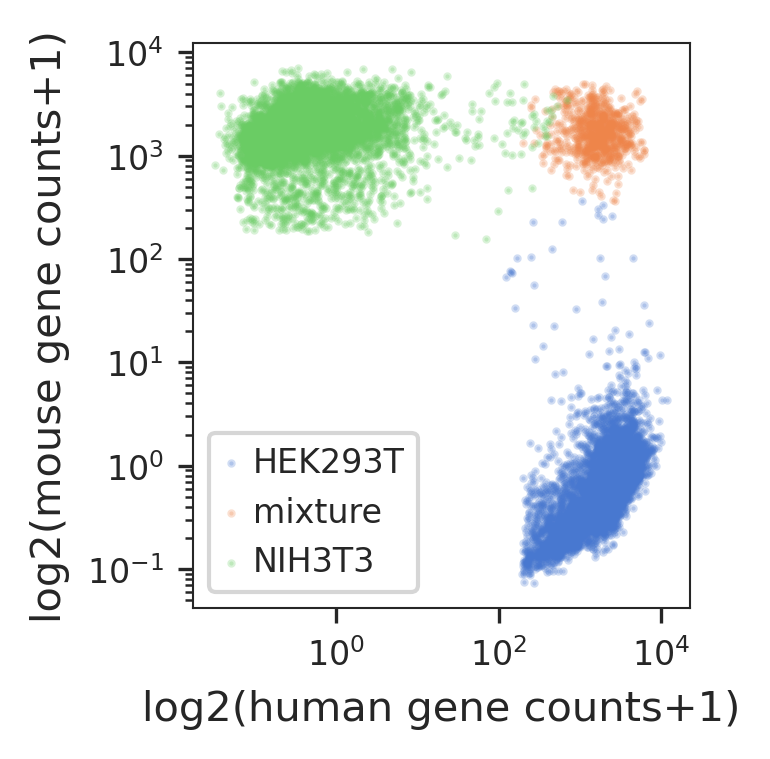

In [52]:
for d in ['dropletsIII']:
# for d in ['cells', 'dropletsI', 'dropletsII', 'dropletsIII']:

    scAR = pd.read_pickle(f'/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/scRNAseq/mixture/scAR_out_{d}/expected_natives.pickle')
    scAR['human gene counts'] = scAR.loc[:,scAR.columns.str.startswith('GRCh38_')].sum(axis=1)
    scAR['mouse gene counts'] = scAR.loc[:,scAR.columns.str.startswith('mm10_')].sum(axis=1)
    scAR['human count ratio'] = scAR['human gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])
    scAR['mouse count ratio'] = scAR['mouse gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])

    scAR['species'] = raw_counts_df['species']

    scAR['log2(human gene counts+1)'] = np.log2(scAR['human gene counts']+1)
    scAR['log2(mouse gene counts+1)'] = np.log2(scAR['mouse gene counts']+1)
    
    plt.figure(figsize=(2.5,2.6))

    for i, spe in enumerate(['HEK293T', 'mixture', 'NIH3T3']):
        tmp = scAR.loc[raw_counts_df[raw_counts_df['species']==spe].index]
        plt.scatter(x=tmp['human gene counts'], y=tmp['mouse gene counts'],rasterized=True, s=1, alpha=0.25, color=sns.color_palette()[i], label=spe);

    plt.legend()
    # plt.title(f'denoised counts')
    # plt.xlim(-1, 14);
    # plt.ylim(-1, 14);
    # plt.xticks(np.arange(0,14,2));
    # plt.yticks(np.arange(0,14,2));
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('log2(human gene counts+1)')
    plt.ylabel('log2(mouse gene counts+1)')
    # plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/1-to-1_human_mouse_counts_{d}_02.pdf')    

Text(0, 0.5, 'log2(mouse gene counts+1)')

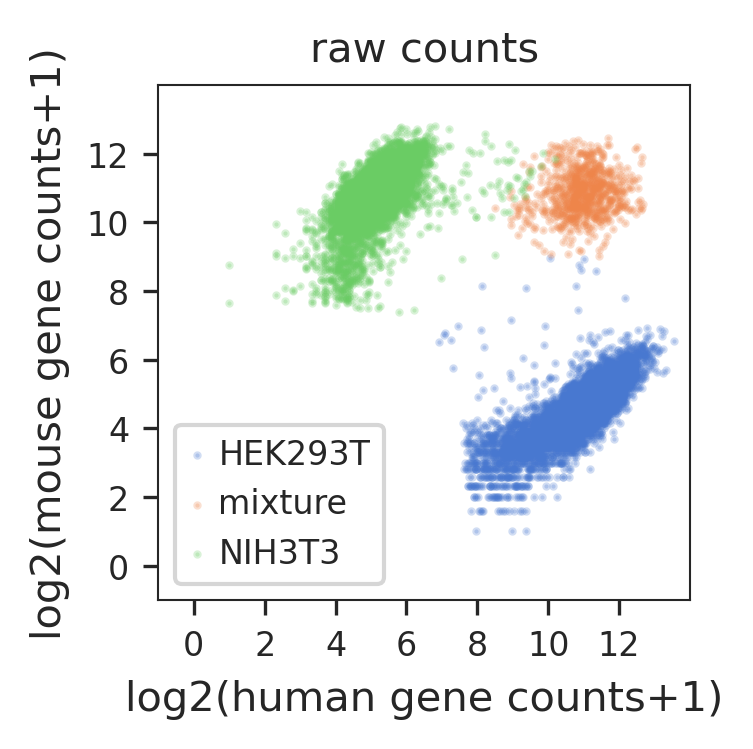

In [53]:
plt.figure(figsize=(2.5,2.6))

for i, spe in enumerate(['HEK293T', 'mixture', 'NIH3T3']):
    tmp = raw_counts_df[raw_counts_df['species']==spe]
    plt.scatter(x=tmp['log2(human gene counts+1)'], y=tmp['log2(mouse gene counts+1)'],rasterized=True, s=1, alpha=0.25, color=sns.color_palette()[i], label=spe);
    
plt.legend()
plt.title(f'raw counts')
plt.xlim(-1, 14);
plt.ylim(-1, 14);
plt.xticks(np.arange(0,14,2));
plt.yticks(np.arange(0,14,2));
plt.xlabel('log2(human gene counts+1)')
plt.ylabel('log2(mouse gene counts+1)')
# plax_jointfig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/1-to-1_human_mouse_counts_01.pdf')

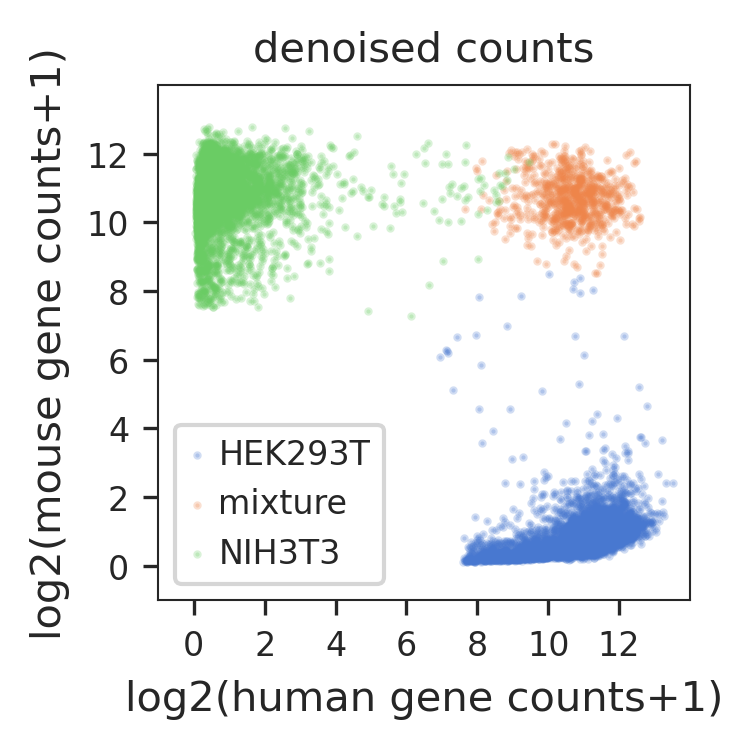

In [54]:
for d in ['dropletsIII']:
# for d in ['cells', 'dropletsI', 'dropletsII', 'dropletsIII']:

    # scAR = pd.read_pickle(f'/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/scRNAseq/mixture/scAR_out_{d}/expected_natives.pickle')
    scAR['human gene counts'] = scAR.loc[:,scAR.columns.str.startswith('GRCh38_')].sum(axis=1)
    scAR['mouse gene counts'] = scAR.loc[:,scAR.columns.str.startswith('mm10_')].sum(axis=1)
    scAR['human count ratio'] = scAR['human gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])
    scAR['mouse count ratio'] = scAR['mouse gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])

    scAR['species'] = raw_counts_df['species']

    scAR['log2(human gene counts+1)'] = np.log2(scAR['human gene counts']+1)
    scAR['log2(mouse gene counts+1)'] = np.log2(scAR['mouse gene counts']+1)
    
    plt.figure(figsize=(2.5,2.6))

    for i, spe in enumerate(['HEK293T', 'mixture', 'NIH3T3']):
        tmp = scAR.loc[raw_counts_df[raw_counts_df['species']==spe].index]
        plt.scatter(x=tmp['log2(human gene counts+1)'], y=tmp['log2(mouse gene counts+1)'],rasterized=True, s=1, alpha=0.25, color=sns.color_palette()[i], label=spe);

    plt.legend()
    plt.title(f'denoised counts')
    plt.xlim(-1, 14);
    plt.ylim(-1, 14);
    plt.xticks(np.arange(0,14,2));
    plt.yticks(np.arange(0,14,2));
    
    plt.xlabel('log2(human gene counts+1)')
    plt.ylabel('log2(mouse gene counts+1)')
    # plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/1-to-1_human_mouse_counts_{d}_02.pdf')    

In [55]:
# for d in ['cells', 'dropletsI', 'dropletsII', 'dropletsIII']:

#     scAR = pd.read_pickle(f'/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/scRNAseq/mixture/scAR_out_{d}/expected_natives.pickle')
#     scAR['human gene counts'] = scAR.loc[:,scAR.columns.str.startswith('GRCh38_')].sum(axis=1)
#     scAR['mouse gene counts'] = scAR.loc[:,scAR.columns.str.startswith('mm10_')].sum(axis=1)
#     scAR['human count ratio'] = scAR['human gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])
#     scAR['mouse count ratio'] = scAR['mouse gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])
    
#     scAR['species'] = raw_counts_df['species']

#     scAR['log2(human gene counts+1)'] = np.log2(scAR['human gene counts']+1)
#     scAR['log2(mouse gene counts+1)'] = np.log2(scAR['mouse gene counts']+1)
    
#     tmp = scAR.join(raw_counts_df[['log2(human gene counts+1)', 'log2(mouse gene counts+1)']], how='left', rsuffix='_raw')
#     tmp1 = tmp.rename(columns={'log2(human gene counts+1)':'denoised counts', 'log2(human gene counts+1)_raw':'raw counts'})
#     tmp1 = tmp1[['denoised counts', 'raw counts', 'species']].melt(id_vars=['species'], var_name='counts', value_name='log2(human gene counts+1)')

#     tmp2 = tmp.rename(columns={'log2(mouse gene counts+1)':'denoised counts', 'log2(mouse gene counts+1)_raw':'raw counts'})
#     tmp2 = tmp2[['denoised counts', 'raw counts', 'species']].melt(id_vars=['species'], var_name='counts', value_name='log2(mouse gene counts+1)')

#     g = sns.displot(x='log2(human gene counts+1)',
#                 hue = 'counts', hue_order=['raw counts', 'denoised counts'], palette=[sns.color_palette()[9], sns.color_palette()[3]],
#                 data=tmp1, kind='kde',
#                 col="species",
#                 fill=True,
#                 facet_kws={'sharey':False},
#                 height=2, aspect=1.2,
#                );
#     g.set(xlim=(-2,16))
#     g.set_titles('{col_name} cells')
#     g.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/hist_{d}_human_gene.pdf')
    
#     g = sns.displot(x='log2(mouse gene counts+1)',
#                 hue = 'counts', hue_order=['raw counts', 'denoised counts'], palette=[sns.color_palette()[9], sns.color_palette()[3]],
#                 data=tmp2, kind='kde',
#                 col="species",
#                 fill=True,
#                 facet_kws={'sharey':False},
#                 height=2, aspect=1.2,
#                );
#     g.set(xlim=(-2,16))
#     g.set_titles('{col_name} cells')
#     g.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/hist_{d}_mouse_gene.pdf')

In [56]:
scAR = pd.read_pickle(f'/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/scRNAseq/mixture/scAR_out_dropletsIII/expected_natives.pickle')

In [57]:
sc.pp.calculate_qc_metrics(filterd_h5, inplace=True)

In [58]:
noise_ratio = 1-scAR.sum(axis=1)/filterd_h5.obs['total_counts']
noise_ratio = noise_ratio.to_frame('noise_ratio')
noise_ratio['species'] = raw_counts_df['species']

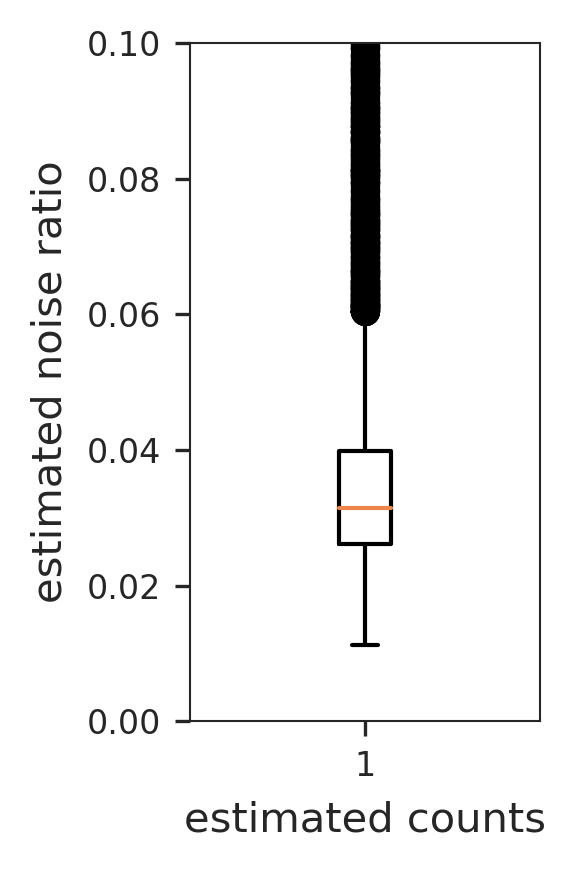

In [59]:
plt.figure(figsize=(2,3))
plt.boxplot(noise_ratio['noise_ratio']);
plt.ylim([0,0.1])
plt.ylabel('estimated noise ratio');
plt.xlabel('estimated counts');

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


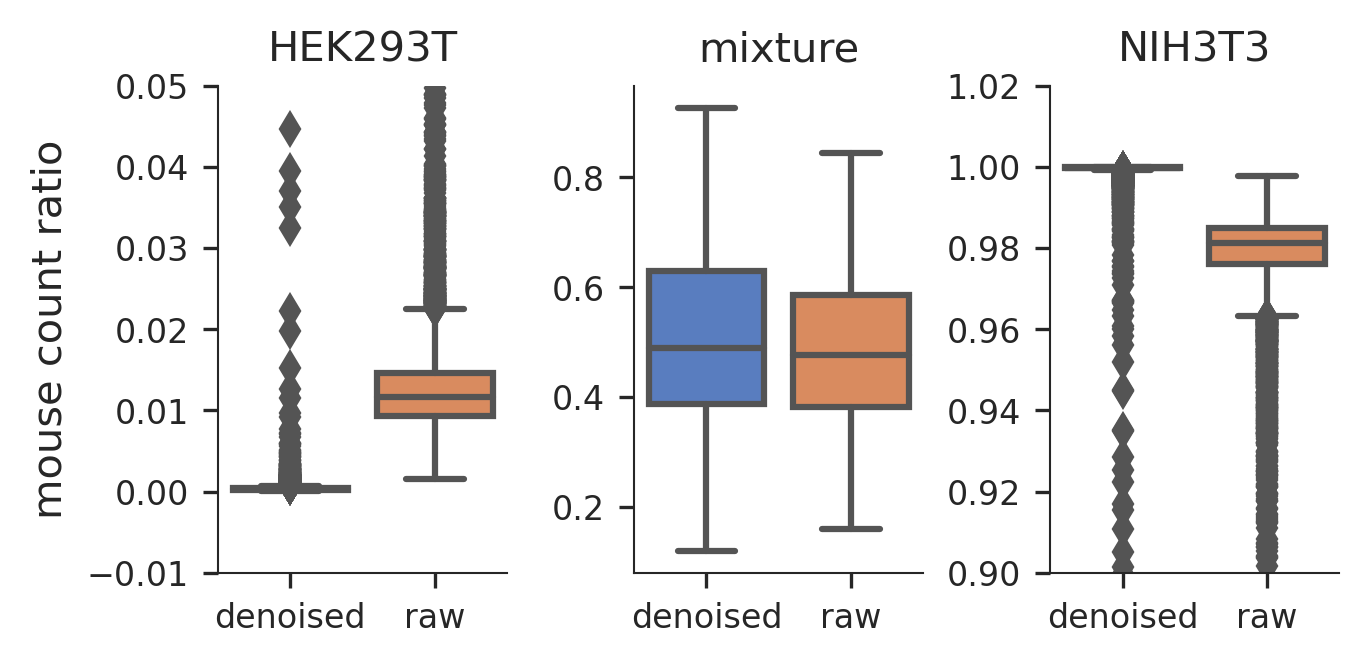

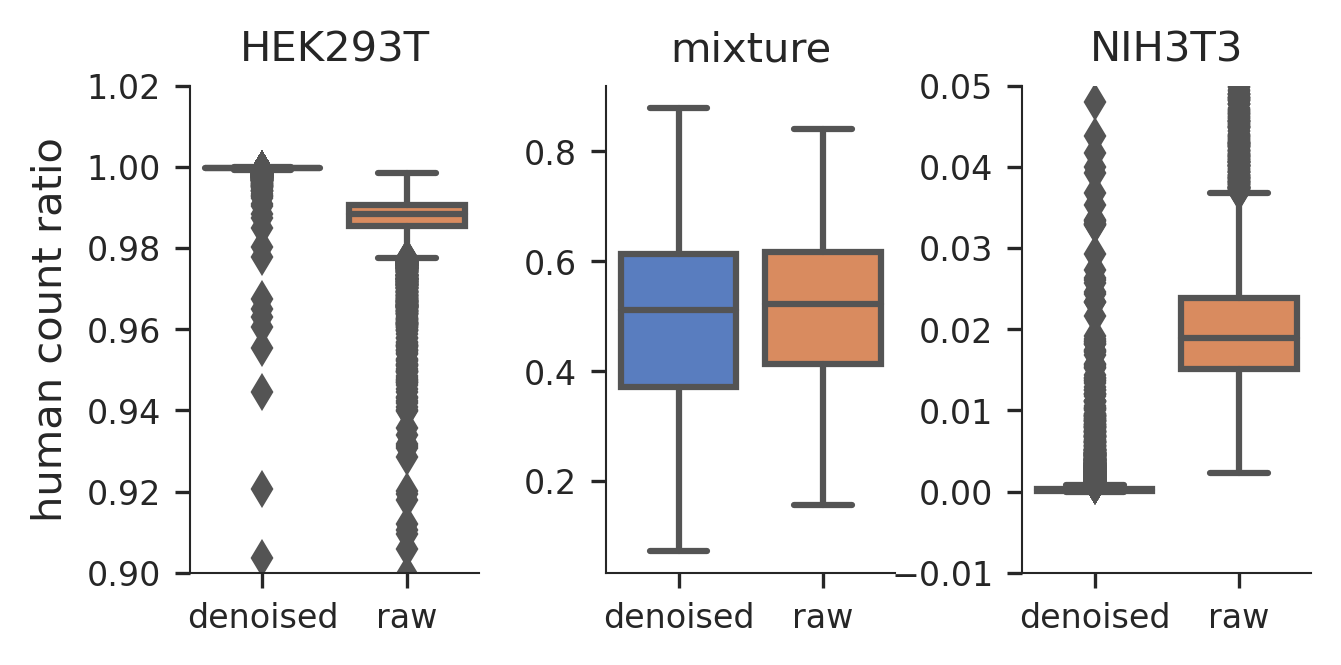

In [60]:
# for d in ['cells', 'dropletsI', 'dropletsII', 'dropletsIII']:
for d in ['dropletsIII']:

    scAR = pd.read_pickle(f'/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/scRNAseq/mixture/scAR_out_{d}/expected_natives.pickle')
    scAR['human gene counts'] = scAR.loc[:,scAR.columns.str.startswith('GRCh38_')].sum(axis=1)
    scAR['mouse gene counts'] = scAR.loc[:,scAR.columns.str.startswith('mm10_')].sum(axis=1)
    scAR['human count ratio'] = scAR['human gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])
    scAR['mouse count ratio'] = scAR['mouse gene counts']/(scAR['mouse gene counts'] + scAR['human gene counts'])
    
    scAR['species'] = raw_counts_df['species']
    
    tmp = scAR[['human count ratio', 'mouse count ratio', 'species']]
    tmp.loc[:,'counts'] = 'denoised'
    tmp1 = raw_counts_df[['human count ratio', 'mouse count ratio', 'species']]
    tmp1.loc[:,'counts'] = 'raw'
    tmp = tmp.append(tmp1)

    ax = sns.catplot(x="counts",
                     y="mouse count ratio",
                     data=tmp, 
                     col='species',
                     kind="box",
                     height=2.5,
                     aspect=.6,
                     sharey=False
                    );
    ax.axes[0,0].set_ylim(-0.01,0.05)
    ax.axes[0,2].set_ylim(0.9,1.02)
    ax.set_titles('{col_name}')
    ax.set_xlabels('')
    # ax.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/boxplot_{d}_mouse_count_ratio.pdf')
    
    ax = sns.catplot(x="counts",
                     y="human count ratio",
                     data=tmp, 
                     col='species',
                     kind="box",
                     height=2.5,
                     aspect=.6,
                     sharey=False
                    );

    ax.axes[0,2].set_ylim(-0.01,0.05)
    ax.axes[0,0].set_ylim(0.9,1.02)
    ax.set_titles('{col_name}')
    ax.set_xlabels('')
    # ax.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig6_scRNAseq/boxplot_{d}_human_count_ratio.pdf')